In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution3D, MaxPooling3D, UpSampling3D, GlobalAveragePooling3D, Dense, Flatten, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import SGD, Adam, Nadam

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
X = np.load("toy_set_v1_20k.npy")
y = np.zeros((20000,2))
y[:10000,0] = 1
y[10000:,1] = 1

idx = np.random.permutation(X.shape[0])
X, y = X[idx], y[idx]

In [3]:
X = (X + 693.0) / 343.0

In [4]:
vsize = (32, 32, 32)

alpha = 2

def model3d(vsize, do_features=False):
    inputs = Input(vsize + (1,))
    sz = 32

    def conv3dparams():
        return { 'activation':ELU(), 'border_mode':'valid', 'init': 'he_normal' }

    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(inputs)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = BatchNormalization()(x)

    x = Convolution3D(sz, 2, 2, 2, activation=ELU(), border_mode='valid')(x)
    x = BatchNormalization()(x)
    x = Convolution3D(2, 1, 1, 1, activation='linear', border_mode='same')(x)
    if not do_features:
        x = Flatten()(x)
        x = Activation('softmax')(x)

    model = Model(input=inputs, output=x)

    return model



In [48]:
model = model3d(vsize)
print(model.summary())

#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

batch_size=32

model.fit(
    X, 
    y, 
    batch_size=batch_size,
    nb_epoch=10,
    validation_split=0.1,
    verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True)])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 32, 32, 32, 1) 0                                            
____________________________________________________________________________________________________
convolution3d_31 (Convolution3D) (None, 30, 30, 30, 32 896         input_4[0][0]                    
____________________________________________________________________________________________________
batchnormalization_28 (BatchNorm (None, 30, 30, 30, 32 128         convolution3d_31[0][0]           
____________________________________________________________________________________________________
convolution3d_32 (Convolution3D) (None, 28, 28, 28, 32 27680       batchnormalization_28[0][0]      
___________________________________________________________________________________________

KeyboardInterrupt: 

In [16]:
np.mean(X)

-693.14036520690922

In [15]:
np.std(X)

343.60703254609479

In [49]:
y_pred = model.predict(X[18000:], batch_size)

In [72]:
y_true = y[18000:]
idxs = (y_true[:,1] - y_pred[:,1]).argsort()[-30:][::-1]

In [73]:
for i in idxs:
    print(y_true[i], y_pred[i], i)

[ 0.  1.] [  9.99999881e-01   6.64567494e-08] 914
[ 0.  1.] [  9.99416351e-01   5.83657180e-04] 1004
[ 0.  1.] [ 0.99742281  0.00257718] 1424
[ 0.  1.] [ 0.99678743  0.00321264] 202
[ 0.  1.] [ 0.99656063  0.00343937] 1917
[ 0.  1.] [ 0.99549329  0.00450671] 1395
[ 0.  1.] [ 0.99081427  0.0091857 ] 854
[ 0.  1.] [ 0.96592551  0.03407448] 1447
[ 0.  1.] [ 0.95815545  0.04184456] 910
[ 0.  1.] [ 0.93500859  0.06499146] 1982
[ 0.  1.] [ 0.57086921  0.42913082] 955
[ 0.  1.] [ 0.49300653  0.50699341] 1457
[ 0.  1.] [ 0.33446273  0.66553724] 1956
[ 0.  1.] [ 0.28528586  0.71471417] 1157
[ 0.  1.] [ 0.25615719  0.74384278] 824
[ 0.  1.] [ 0.2149858   0.78501415] 976
[ 0.  1.] [ 0.20126981  0.79873019] 1559
[ 0.  1.] [ 0.19700423  0.8029958 ] 474
[ 0.  1.] [ 0.12091742  0.8790825 ] 1695
[ 0.  1.] [ 0.10128577  0.89871424] 1738
[ 0.  1.] [ 0.06241431  0.93758565] 132
[ 0.  1.] [ 0.05942618  0.94057381] 1840
[ 0.  1.] [ 0.04571332  0.95428663] 446
[ 0.  1.] [ 0.04362948  0.95637053] 1219
[ 0.  

In [20]:
from pylab import *
%matplotlib inline

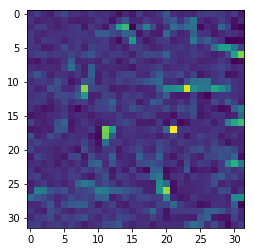

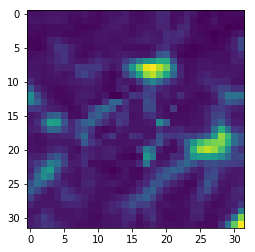

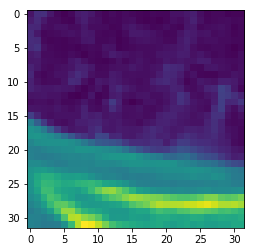

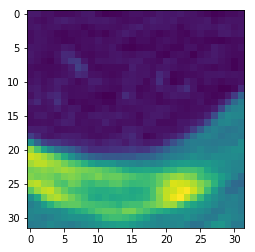

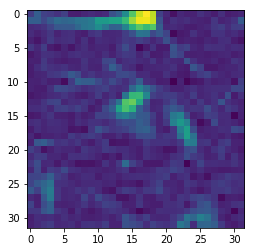

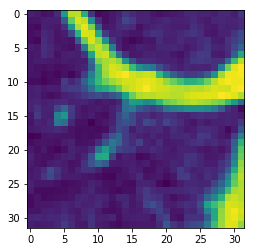

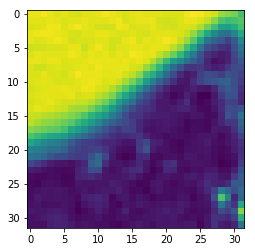

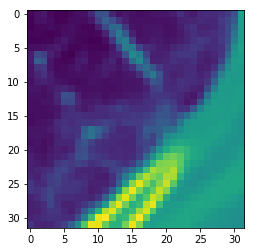

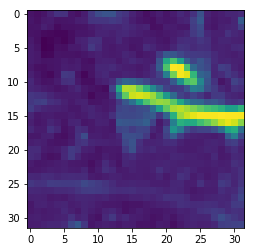

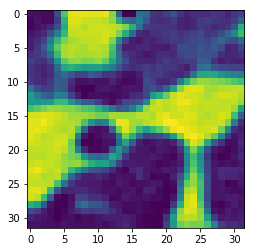

In [75]:
for i in idxs[:10]:
    imshow(X[i+18000,16,:,:,0])
    show()

In [76]:
import data

/home/alex/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [77]:
pid = data.luna16_get_patient_ids()[0]

In [78]:
image = data.luna16_get_image(pid)

In [86]:
cubes = []
for i in range(0, image.shape[0], 32):
    for j in range(0, image.shape[1], 32):
        for k in range(0, image.shape[2], 32):
            cube = image[i:i+32,j:j+32,k:k+32]
            if (cube.shape != (32,32,32)):
                continue
            cubes.append(cube)
cubes = np.stack(cubes)
cubes = (cubes + 693.0) / 343.0
cubes = cubes[...,None]

In [87]:
cubes.shape

(847, 32, 32, 32, 1)

In [88]:
cps = model.predict(cubes, batch_size)

In [92]:
np.count_nonzero(cps[:,1] > 0.5)

423

In [95]:
image.shape[0] / 32, image.shape[1] / 32, image.shape[2] / 32

(7.21875, 11.25, 11.25)

In [97]:
cps = cps[:,1].reshape((7,11,11))

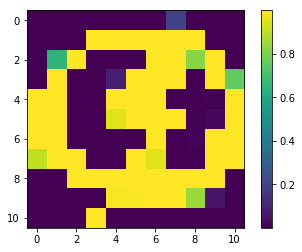

In [111]:
imshow(cps[3])
colorbar()

In [15]:
def preprocess(image):
    return (image + 693.0) / 343.0

In [49]:
model.save_weights('tmp.h5')

In [50]:
model2 = model3d((128,128,128), do_features=True)

In [51]:
# NOTE loading by_name=True fails, because the auto-generated layer names are counting up in keras for each layer class globally
# NOTE on the other hand plain loading works, since the missing top two layers don't have weights
model2.load_weights('tmp.h5')

In [10]:
def softmax(x):
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

In [12]:
import data

/home/ubuntu/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [13]:
pid = data.luna16_get_patient_ids()[0]

In [52]:
image = data.luna16_get_image(pid)
image = preprocess(image)

In [17]:
# this is around 360ms
result = model2.predict(image[115-64:115+64,130-64:130+64,130-64:130+64].reshape((1,128,128,128,1)), batch_size=1)

In [18]:
# TODO this needs a more efficient calculation of point-wise softmax

p = np.zeros(result.shape).reshape((-1,2))
r = result.reshape((-1,2))
for i in range(r.shape[0]):
    p[i] = softmax(r[i])
p = p.reshape(result.shape)

In [44]:
def softmax_activations(x):
    r = x.reshape((-1,2))
    r_max = np.max(r, axis=-1)
    r_max = r_max[...,None]
    r_sum = np.sum(np.exp(r - r_max), axis=-1)
    r_sum = r_sum[...,None]
    p = np.exp(r - r_max) / r_sum
    p = p.reshape(x.shape)
    return p

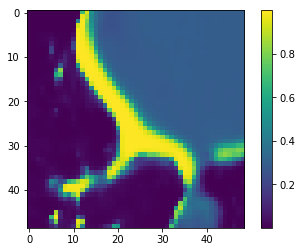

In [21]:
imshow(p[0,25,:,:,1])
colorbar()

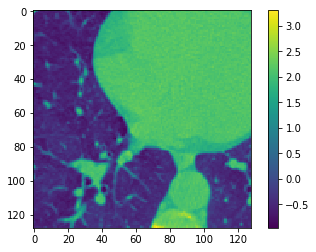

In [22]:
imshow(image[115,130-64:130+64,130-64:130+64])
colorbar()

In [23]:
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128, 128, 128, 0                                            
____________________________________________________________________________________________________
convolution3d_11 (Convolution3D) (None, 126, 126, 126, 896         input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorm (None, 126, 126, 126, 128         convolution3d_11[0][0]           
____________________________________________________________________________________________________
convolution3d_12 (Convolution3D) (None, 124, 124, 124, 27680       batchnormalization_10[0][0]      
___________________________________________________________________________________________

In [61]:
full_result = np.zeros((image.shape[0], image.shape[1], image.shape[2], 2))
for i in range(0, image.shape[0]//96):
    for j in range(0, image.shape[1]//96):
        for k in range(0, image.shape[2]//96):
            input_ = image[i*96:i*96+128,j*96:j*96+128,k*96:k*96+128]
            if input_.shape != (128,128,128):
                input_ = np.pad(input_, ((0, 128-input_.shape[0]), (0, 128-input_.shape[1]), (0, 128-input_.shape[2])), 'constant')
            result = model2.predict(input_.reshape((1,128,128,128,1)), batch_size=1)
            full_result[i*49:(i+1)*49, j*49:(j+1)*49, k*49:(k+1)*49,:] = result

In [30]:
full_result.shape

(291, 300, 300, 2)

In [62]:
full_result_p = softmax_activations(full_result)

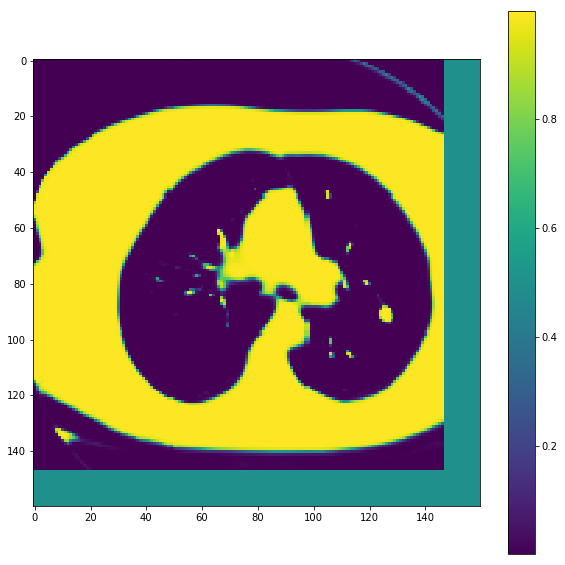

In [72]:
figure(figsize=(10,10))
imshow(full_result_p[90,:160,:160,1])
colorbar()

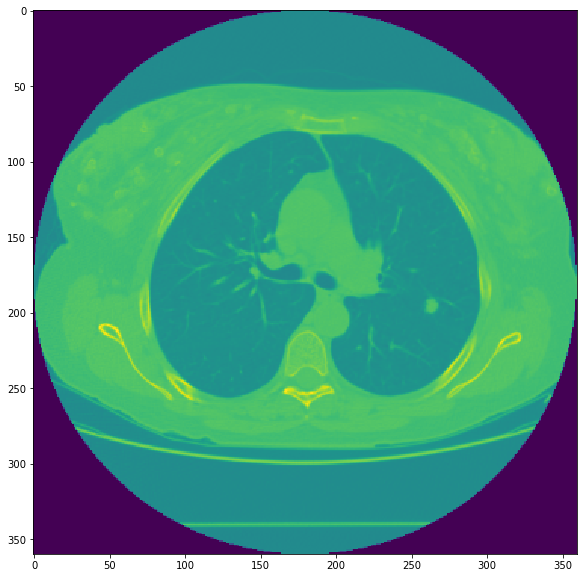

In [71]:
figure(figsize=(10,10))
imshow(image[179+16])

In [ ]:
patient_ids = data.luna16_get_patient_ids()
pid = [ x for x in patient_ids if in '5b41250' ][0]

In [59]:
image = np.load('5b412509bc40a3aeb3b5efef1fdfcfc9.npy', mmap_mode='r')
image = preprocess(image)

In [58]:
image.shape

(302, 360, 360)